# Imports

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

# Overview

This is just a quick overview of what I will be talking about in this section.  Which is basically comparing Numpy vs TensorFlow vs. PyTorch

![overviewIMG](docs/comparison.png)

# Architecture

Train a two-layer ReLu Netowrk on random data with L2 Loss

# Tensor Flow

In [2]:
import numpy as np
import tensorflow as tf

In [3]:
np.random.seed(64)

## Inefficient Method

CPU GPU bottle-neck because we are copying CPU and GPU everytime step

### Generate Computational Graphs

In [4]:
N,D,H = 64, 1000, 1000
# These are the input nodes of the graph and are fed into the graph
# These are not allocating to memory
x = tf.placeholder(tf.float32,shape=(N,D))
y = tf.placeholder(tf.float32,shape=(N,D))
w1 = tf.placeholder(tf.float32,shape=(D,H))
w2 = tf.placeholder(tf.float32,shape=(H,D))

# Using these symbolic values we will perform tensor operations on the.  
# In this case forward propagation.
h = tf.maximum(tf.matmul(x,w1),0) # matrix multiplacation
y_pred = tf.matmul(h,w2) # ReLU
diff = y_pred - y
loss = tf.reduce_mean(tf.reduce_sum(diff**2,axis=1)) # L2 loss

# This is as tensor flow to calculate the gradients of the loss wrt to w1 and w2
# This avoids creating back-prop code
grad_w1, grad_w2 = tf.gradients(loss,[w1,w2])

### Run the Graph

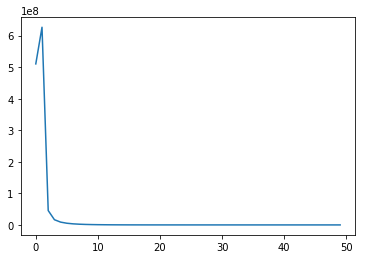

In [5]:
# Entering a tensor flow session
lossRunning = []
with tf.Session() as sess:
    
    # These are finally concrete values into the graph.  
    # These are fed in using numpy
    values = {x:np.random.randn(N,D),
              w1:np.random.randn(D,H),
              w2:np.random.randn(H,D),
              y:np.random.randn(N,D)
             }
    
    #Hyper-Parameters
    learning_rate = 1e-5
    numItr = 50
    
    # Training the model
    for itr in range(numItr):
        # In this section we are basically saying we want to calculate loss,dw1,dw2
        # and feeding in a dictionary of values which were specified by the 
        # palceholders
        out = sess.run([loss,grad_w1,grad_w2],feed_dict = values)

        # inpack all the output and you get the loss and the gradients
        loss_val,grad_w1_val,grad_w2_val = out
        lossRunning.append(loss_val)
        
        # Update the weights
        values[w1] -= learning_rate *grad_w1_val
        values[w2] -= learning_rate *grad_w2_val

plt.plot(lossRunning)

## Efficient

These are the following changes that have been made to make it more efficient:
- Changed the weights to be variables so that it persists in the graph between calls
    - But because these are varible TF needs to know what are these values and we can initialize them with **tf.random_normal** function in TF

### Generate Computation Graphs Efficient

In [6]:
N,D,H = 64, 1000, 1000
# These are the input nodes of the graph and are fed into the graph
# These are not allocating to memory
x = tf.placeholder(tf.float32,shape=(N,D))
y = tf.placeholder(tf.float32,shape=(N,D))
# NEW: now varible and tell TF on how they should be initialized
w1 = tf.Variable(tf.random_normal((D,H)))
w2 = tf.Variable(tf.random_normal((H,D)))

# Using these symbolic values we will perform tensor operations on the.  
# In this case forward propagation.
h = tf.maximum(tf.matmul(x,w1),0) # matrix multiplacation
y_pred = tf.matmul(h,w2) # ReLU

# NEW: 
# diff = y_pred - y
# loss = tf.reduce_mean(tf.reduce_sum(diff**2,axis=1)) # L2 loss
# we can use predefined common loss functions instead of performing these
# tensor calculation
loss = tf.losses.mean_squared_error(y_pred,y)

# This is as tensor flow to calculate the gradients of the loss wrt to w1 and w2
# This avoids creating back-prop code
grad_w1, grad_w2 = tf.gradients(loss,[w1,w2])

# NEW: these weights are now inside the graphs so we need to perform an assign 
# which mutates these values inside the computational graph.  These values will
# persist in each iteration
learning_rate = 1e-5
new_w1 = w1.assign(w1 - learning_rate * grad_w1)
new_w2 = w2.assign(w2 - learning_rate * grad_w2)

# NEW: perform optimization on the gradients
# There are other optimization techniques such as ADAM, RMSprop
optimizer = tf.train.GradientDescentOptimizer(1e-5)

# we need to add this dummy node that depends on weights to force TF to update
# This line automatically detects that the loss if based on w1 and w2 and knows
# that these are trainable parameters.  This line then added nodes in the 
# computational graph that says w1 and w2 needs to be updataes.
updates = optimizer.minimize(loss)

### Run the Graphs Efficient

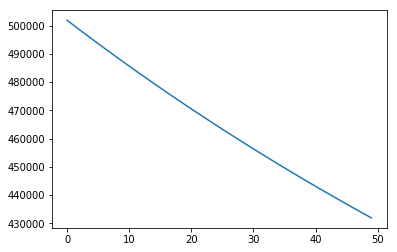

In [7]:
lossRunningEfficient = []
with tf.Session() as sess:
    #Initialize the weights and all other values inside the graphs    
    sess.run(tf.global_variables_initializer())
    
    # Values comming into the graph in a dictionary called values
    values = {x: np.random.randn(N,D),
             y: np.random.randn(N,D)}
    
    # Run many times to train
    for t in range(50):
        # so we want loss and now updates 
        # (dummy nodes that depend on new_w2 and new_w2)
        # This dummy node returns null but it forces TF to update the weights
        loss_val,_ = sess.run([loss,updates],feed_dict=values)    
        lossRunningEfficient.append(loss_val)
        
plt.plot(lossRunningEfficient)

We may not have seen any computation improvements here because we are dealing with small amounts of datasets but this is technically more efficient as it does not require any GPU to CPU copying.

We also know that it is training because of the decreasing loss function.

## High Level Wrappers

- In the previous examples the bias is not present here because we have to update them and initialize them and the code starts getting larger and larger.  In this section we will look at various common wrappers over TF to make our lives easier

We are only looking at 2 here but there are several others.  Please refer to the following wrappers.
- Third Party Libs
    - [Keras](https://keras.io/) 
    - [TFLearn](http://tflearn.org/)
- Google
    - These come with TF
        - [TensorLayer](https://tensorlayer.readthedocs.io/en/latest/)
        - [tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers)
        - [TF-Slim](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/slim)
        - [tf.contrib.learn](https://www.tensorflow.org/api_docs/python/tf/contrib/learn)
    - Doesn't come with TF
        - [Pretty Tesnor](https://github.com/google/prettytensor)
        - [Sonnets](https://github.com/deepmind/sonnet) FROM DeepMind
        
NOTE: There are some pre-trained examples for transfer learning for Keras and TF-Slim

### Tensor Flow Layers

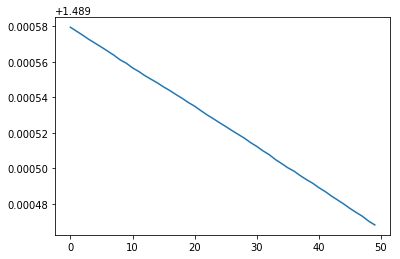

In [8]:
N,D,H = 64, 1000, 1000
# These are the input nodes of the graph and are fed into the graph
# These are not allocating to memory
x = tf.placeholder(tf.float32,shape=(N,D))
y = tf.placeholder(tf.float32,shape=(N,D))

# NEW: this is performing xavier normalization strategy: 
# For more detail go to: http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf
init = tf.contrib.layers.xavier_initializer()

# NEW: we can use layers to automatically set up weigths and bias
# NOTE: these layers aslo have defined activation function.  In this example we
# use the ReLU activation funciton
# With this line it is automatically setting up [w1,b1] with the correct size
# based on our specification of units
h = tf.layers.dense(inputs=x,
                    units=H,
                    activation=tf.nn.relu,
                    kernel_initializer=init)
y_pred = tf.layers.dense(inputs=h,
                         units=D,
                         kernel_initializer=init)

loss = tf.losses.mean_squared_error(y_pred,y)

optimizer = tf.train.GradientDescentOptimizer(1e-5)
updates = optimizer.minimize(loss)

# ------------ Run the graph ----------------
lossRunningTFLayers = []
with tf.Session() as sess:
    #Initialize the weights and all other values inside the graphs    
    sess.run(tf.global_variables_initializer())
    
    # Values comming into the graph in a dictionary called values
    values = {x: np.random.randn(N,D),
             y: np.random.randn(N,D)}
    
    # Run many times to train
    for t in range(50):
        # so we want loss and now updates 
        # (dummy nodes that depend on new_w2 and new_w2)
        # This dummy node returns null but it forces TF to update the weights
        loss_val,_ = sess.run([loss,updates],feed_dict=values)    
        lossRunningTFLayers.append(loss_val)
        
plt.plot(lossRunningTFLayers)

### Keras

In [18]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD

# Data
N,D,H = 64, 1000, 1000
x = np.random.randn(N,D)
y = np.random.randn(N,D)

# New: Define model objects as a sequence of layers
model = Sequential()
# First Layer
model.add(Dense(input_dim=D,output_dim=H))
model.add(Activation('relu'))
# Second Layer
model.add(Dense(input_dim=H,output_dim=D))

# NEW: define an optimization object to calculate the gradients
optimizaer = SGD(lr=1e-5)

# NEW: specify a loss function
model.compile(loss='mean_squared_error',
             optimizer = optimizer,
             metrics=['accuracy'])
          
# New: train the model
history = model.fit(x,
                    y,
                    validation_split = 0.33,                    
                    nb_epoch=50,
                    batch_size=10,
                    verbose=0)

C:\Users\HP\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=1000, units=1000)`
  del sys.path[0]
C:\Users\HP\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=1000, units=1000)`
  app.launch_new_instance()
C:\Users\HP\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:32: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


In [20]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


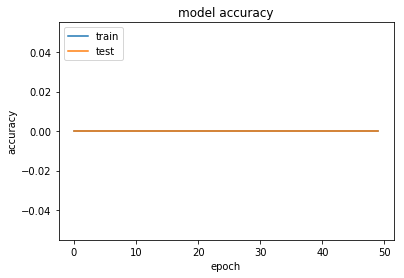

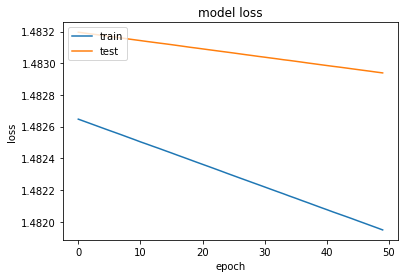

In [21]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

This is good generalization.

# PyTorch

Three Layer of abstaction
- **Tensor**: Imperative ndarray,, but runs on GPU
    - same as np array
- **Variables**: Node in a computation graph; stores data and gradients
    - tensor, variable, placeholder
- **Module**: A NN layer; may store state or learnable weights 
    - same as keras, tf.layers or TFSlim

In [69]:
import torch
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

## Vanilla Implementation

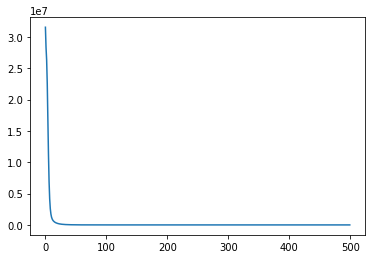

In [68]:
# explicitly say the type of variable we are using which is the torch tensor
dtype = torch.FloatTensor
# to run on GPU all you need is to change the variables to 
#dtype = torch.cuda.FloatTensor

N, D_in, H, D_out = 64,1000,100,10
x = torch.randn(N,D_in).type(dtype)
y = torch.randn(N,D_out).type(dtype)
w1 = torch.randn(D_in,H).type(dtype)
w2 = torch.randn(H,D_out).type(dtype)

learning_rate = 1e-6

torchLoss = []
for t in range(500):
    # Forward Pass
    h=x.mm(w1)
    h_relu = h.clamp(min=0)
    y_pred = h_relu.mm(w2)
    loss = (y_pred - y).pow(2).sum()
    torchLoss.append(loss)
    
    # backprop
    grad_y_pred = 2.0 * (y_pred-y)
    grad_w2 = h_relu.t().mm(grad_y_pred)
    grad_h_relu = grad_y_pred.mm(w2.t())
    grad_h = grad_h_relu.clone()
    grad_h[h<0] = 0
    grad_w1 = x.t().mm(grad_h)
    
    # weights update
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2

plt.plot(torchLoss)

## Auto Gradient Descent

In [45]:
N, D_in, H, D_out = 64,1000,100,10

# NEW: now we are placing them in a varible node in the computation graph
# and telling PT which variable we want to have gradients calculated
# in this case these are the weights
x = Variable(torch.randn(N,D_in),requires_grad=False)
y = Variable(torch.randn(N,D_out),requires_grad=False)
w1 = Variable(torch.randn(D_in,H),requires_grad=True)
w2 = Variable(torch.randn(H,D_out),requires_grad=True)

learning_rate = 1e-6

torchLossAutoGrad = []

# NOTE: x.data is a tensor 
#       x.grad is a variable of gradients shape as x.data
#       x.grad.data is a tensor of gradients
for t in range(500):
    # Forward Pass
    y_pred = x.mm(w1).clamp(min=0).mm(w2)
    loss = (y_pred - y).pow(2).sum()
    
    # backprop
    if w1.grad:
        w1.grad.data.zero_()
    if w2.grad:
        w2.grad.data.zero_()
    loss.backward()
    
    # weights update
    w1.data -= learning_rate * w1.grad.data
    w2.data -= learning_rate * w2.grad.data

plt.plot(torchLossAutoGrad)

RuntimeError: bool value of Tensor with more than one value is ambiguous

### New Autograd functions

You can create your functions using tensor calculations

In [49]:
class ReLU(torch.autograd.Function):
    def forward(self,x):
        self.save_for_backward(x)
        return x.clamp(min=0)
    
    def backward(self,grad_y):
        x, = self.saved_tensors
        grad_input = grad_y.clone()
        grad_input[x<0] = 0
        return grad_input

In [50]:
N, D_in, H, D_out = 64,1000,100,10

# NEW: now we are placing them in a varible node in the computation graph
# and telling PT which variable we want to have gradients calculated
# in this case these are the weights
x = Variable(torch.randn(N,D_in),requires_grad=False)
y = Variable(torch.randn(N,D_out),requires_grad=False)
w1 = Variable(torch.randn(D_in,H),requires_grad=True)
w2 = Variable(torch.randn(H,D_out),requires_grad=True)

learning_rate = 1e-6

torchLossAutoGradReLu = []

# NOTE: x.data is a tensor 
#       x.grad is a variable of gradients shape as x.data
#       x.grad.data is a tensor of gradients
for t in range(500):
    # Forward Pass
    relu = ReLU()
    y_pred = x.mm(w1).clamp(min=0).mm(w2)
    loss = (y_pred - y).pow(2).sum()
    
    # backprop
    if w1.grad:
        w1.grad.data.zero_()
    if w2.grad:
        w2.grad.data.zero_()
    loss.backward()
    
    # weights update
    w1.data -= learning_rate * w1.grad.data
    w2.data -= learning_rate * w2.grad.data

plt.plot(torchLossAutoGradReLu)

RuntimeError: bool value of Tensor with more than one value is ambiguous

## Wrapper

These are equivalent to Keras and layers in TF.  We will be talking about the **nn package**

C:\Users\HP\Anaconda2\envs\py36\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


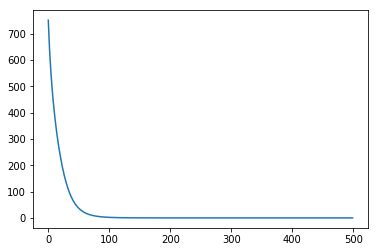

In [66]:
N, D_in, H, D_out = 64,1000,100,10

x = Variable(torch.randn(N,D_in),requires_grad=False)
y = Variable(torch.randn(N,D_out),requires_grad=False)

# New: Define our model as sequences of layers
model  = torch.nn.Sequential(torch.nn.Linear(D_in,H),
                            torch.nn.ReLU(),
                            torch.nn.Linear(H,D_out))

# New: define our common loss function
loss_fn = torch.nn.MSELoss(size_average=False)
learning_rate = 1e-4

torchLossNNWrapper = []
for t in range(500):
    # Forward Pass
    y_pred = model(x)
    loss = loss_fn(y_pred,y)
    torchLossNNWrapper.append(loss)
    
    # backprop
    model.zero_grad()
    loss.backward()
    
    # weights update
    for param in model.parameters():
        param.data -= learning_rate * param.grad.data

plt.plot(torchLossNNWrapper)

### With optimizer

C:\Users\HP\Anaconda2\envs\py36\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


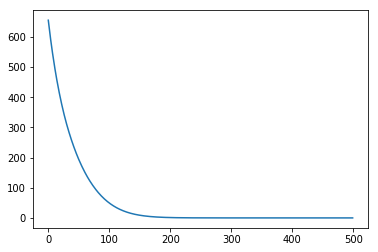

In [65]:
N, D_in, H, D_out = 64,1000,100,10

x = Variable(torch.randn(N,D_in),requires_grad=False)
y = Variable(torch.randn(N,D_out),requires_grad=False)

# Define our model as sequences of layers
model  = torch.nn.Sequential(torch.nn.Linear(D_in,H),
                            torch.nn.ReLU(),
                            torch.nn.Linear(H,D_out))

# Define our common loss function
loss_fn = torch.nn.MSELoss(size_average=False)
learning_rate = 1e-4


# NEW: This is a backprop optimizer. In this example we use adam
optimizer = torch.optim.Adam(model.parameters(),
                            lr=learning_rate)

torchLossNNWrapperOptimizer = []
for t in range(500):
    # Forward Pass
    y_pred = model(x)
    loss = loss_fn(y_pred,y)
    torchLossNNWrapperOptimizer.append(loss)
    
    # backprop
    model.zero_grad()
    loss.backward()
    
    # NEW: Instead of manually updating we can use the optimizer step
    optimizer.step()
    

plt.plot(torchLossNNWrapperOptimizer)

### Module

You can think of a module as a layer where it contains weights, other modules, or states.  But it is a NN layer and it has inputs and output variables.

In [63]:
class TwoLayerNet(torch.nn.Module):
    # intialize two child layers using the nn wrapper
    def __init__(self,D_in,H,D_out):
        super(TwoLayerNet,self).__init__()
        self.linear1 = torch.nn.Linear(D_in,H)
        self.linear2 = torch.nn.Linear(H,D_out)
    
    # Note that you do not need to calculate the gradient because nn will take 
    # care of it
    def forward(self,x):
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred

C:\Users\HP\Anaconda2\envs\py36\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


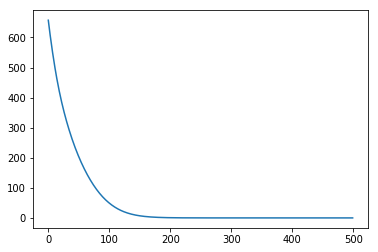

In [64]:
N, D_in, H, D_out = 64,1000,100,10

x = Variable(torch.randn(N,D_in),requires_grad=False)
y = Variable(torch.randn(N,D_out),requires_grad=False)

# New: this is based on the class we just made
model = TwoLayerNet(D_in,H,D_out)

# Define our common loss function
loss_fn = torch.nn.MSELoss(size_average=False)

# Define Optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(),
                            lr=learning_rate)

torchLossNNWrapperOptimizerModule = []
for t in range(500):
    # Forward Pass
    y_pred = model(x)
    loss = loss_fn(y_pred,y)
    torchLossNNWrapperOptimizerModule.append(loss)
    
    # backprop
    model.zero_grad()
    loss.backward()
    
    # NEW: Instead of manually updating we can use the optimizer step
    optimizer.step()
    

plt.plot(torchLossNNWrapperOptimizerModule)

### Data Loaders

These are wraps a dataset and provide minibatching, shuffling, and multi-threading for you.

NOTE: if you need to load custom data, you just have to write your own Dataset class

C:\Users\HP\Anaconda2\envs\py36\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


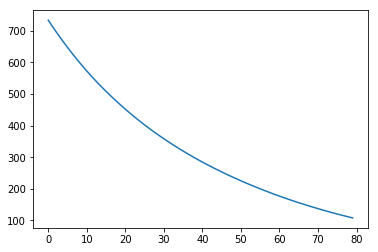

In [71]:
# DATA
N, D_in, H, D_out = 64,1000,100,10
x = Variable(torch.randn(N,D_in),requires_grad=False)
y = Variable(torch.randn(N,D_out),requires_grad=False)

# NEW: generate a datasetloader class in practice
loader = DataLoader(TensorDataset(x,y),batch_size=8)

# Module class we made earlier that defines our two layer NN
model = TwoLayerNet(D_in,H,D_out)

# Define our common loss function
loss_fn = torch.nn.MSELoss(size_average=False)

# Define Optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(),
                            lr=learning_rate)

torchLossNNWrapperOptimizerModuleDataLoaders = []

# New: iterate over loader to form minibatches
for epoch in range(10):
    for x_batch,y_batch in loader:
        # Note that the loaders use tensors so you need to call Variable
        x_var, y_var = Variable(x), Variable(y)
        # Forward Pass
        y_pred = model(x)
        loss = loss_fn(y_pred,y)
        torchLossNNWrapperOptimizerModuleDataLoaders.append(loss)

        # backprop
        model.zero_grad()
        loss.backward()

        # NEW: Instead of manually updating we can use the optimizer step
        optimizer.step()
    

plt.plot(torchLossNNWrapperOptimizerModuleDataLoaders)

## Pretrained Data for Transfer Learning

It is really simple to use pre-trained networks you simply just use the [torchvision](https://github.com/pytorch/vision) module.

You need to install this via forking the github page.

But it is simply using the following lines of code:
- alexnet = torchvision.models.alexnet(pretrained=True)
- vgg16 = torchvision.models.vgg16(pretrained=True) 
- resnet101 = torchvision.models.resnet101(pretrained=True)

## Visdom - similar to tensor board

This is similar to tensor board and adds logging to your code and then visualize them in the browser.  NOTE: vomputational graph structure are not yet possible.

# Comparison

![overviewIMG](docs/StaticVsDynamic.png)